# Make new hdf5 files and investigate images for correct labelling

<b> What data do we have now? <b>

1. Stimulated 14h (or 16h) -> labelled as 0
2. Unstimulated -> labelled as 1
3. ATG5 KO (stimulated but that doesn’t matter, this KO supersedes the stim status [probably looks like unstimulated data]) -> labelled as 2
4. Stimulated timecourse data -> labelled as 3
5. EI24 KO timecourse data (more similar to unstim) -> labelled as 4
6. Screening data (similar to stim) -> labelled as 5


<b> What are we doing in this section? <b>

Make new hdf5 files for correct labelling of our data from different biological classes and investigate the images before labelling. This notebook also visualizes the images for all bioloical classes we have as an overview.


In [1]:
!pip install torch-intermediate-layer-getter
!pip install umap-learn
!pip install leidenalg
!pip install scanpy==1.9.6
!pip install anndata umap-learn
!pip install watermark

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Created wheel for torch-intermediate-layer-getter: filename=torch_intermediate_layer_getter-0.1.post1-py3-none-any.whl size=3724 sha256=9e9b7b309c9b3d1d5c8d38f1384209bc8d8b510341656139a0865dd6b2798457
  Stored in directory: /tmp/pip-ephem-wheel-cache-fmramng3/wheels/6a/11/c0/30d81aa26172d10d68ffaf352b0762eb9fe0a5f5dcf3de63e0
Successfully built torch-intermediate-layer-getter
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 88 kB 3.4 MB/s eta 0:00:011
     |████████████████████████████████| 56 kB 16.9 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 2.0 MB 3.3 MB/s eta 0:00:01
     |███

In [2]:
import os
import wandb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.notebook import tqdm
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, random_split, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, balanced_accuracy_score
import sys
import seaborn as sn
from torch.utils.tensorboard import SummaryWriter
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter
import umap
import scanpy as sc
import anndata as ad
import re
from collections import Counter
import random
from torch.utils.data import Subset
import h5py
import random
import pickle
import glob

from sparcscore.ml.datasets import HDF5SingleCellDataset
# from sparcscore.pipeline.project import TimecourseProject, Project
# from sparcscore.pipeline.workflows import MultithreadedWGATimecourseSegmentation, WGATimecourseSegmentation, MultithreadedCytosolCellposeTimecourseSegmentation, ShardedWGASegmentation, ShardedDAPISegmentationCellpose, WGASegmentation, DAPISegmentationCellpose
from sparcscore.pipeline.extraction import HDF5CellExtraction, TimecourseHDF5CellExtraction
from sparcscore.pipeline.classification import MLClusterClassifier
from sparcscore.ml.pretrained_models import autophagy_classifier2_1

/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/u

NOTE! Installing ujson may make loading annotations faster.


In [6]:
# 3 replicates of single cell image EI24 KO timecourse data
os.chdir('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/')
files = os.listdir()
print("Files in 231018_EI24_timecourse_phenix:")
for file in files:
    print(file)
print("\n")

Files in 231018_EI24_timecourse_phenix:
231018_0318_EI24_fixed_tc
231018_0317_EI24_fixed_tc
231018_0316_EI24_fixed_tc




Investigating EI24KO in more detail:

In [18]:
hdf5_file_path = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/single_cells.h5'

with h5py.File(hdf5_file_path, 'r') as hdf5:
    single_cell_data = hdf5['single_cell_index_labelled'][:]

    unique_values = np.unique(single_cell_data[:, 7])
    print(unique_values)

[b'EI24KO_1' b'EI24KO_2' b'WT_1' b'WT_2']


In [18]:
with h5py.File(hdf5_file_path, 'r') as hdf5:
    unique_values = np.unique(hdf5['single_cell_index_labelled'][:, 4])
    print(unique_values)

[b'Timepoint001']


In [19]:
with h5py.File(hdf5_file_path, 'r') as hdf5:
    unique_values = np.unique(hdf5['single_cell_index_labelled'][:, 8])
    print(unique_values)

[b'0d' b'10h' b'12h' b'14h' b'2h' b'4h' b'6h' b'8h']


Unique Timepoints: [b'Timepoint001']


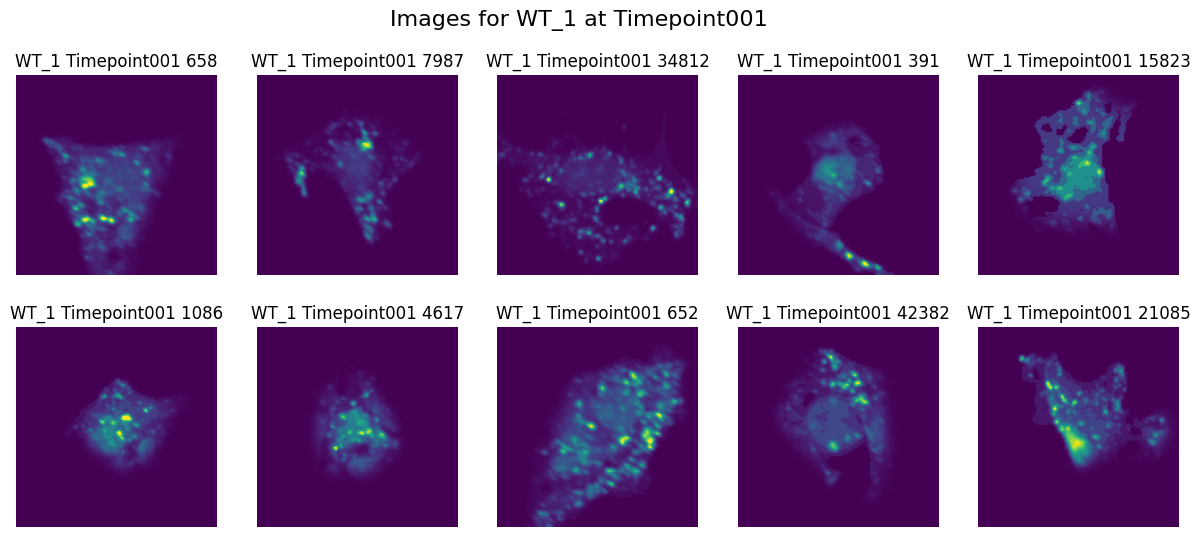

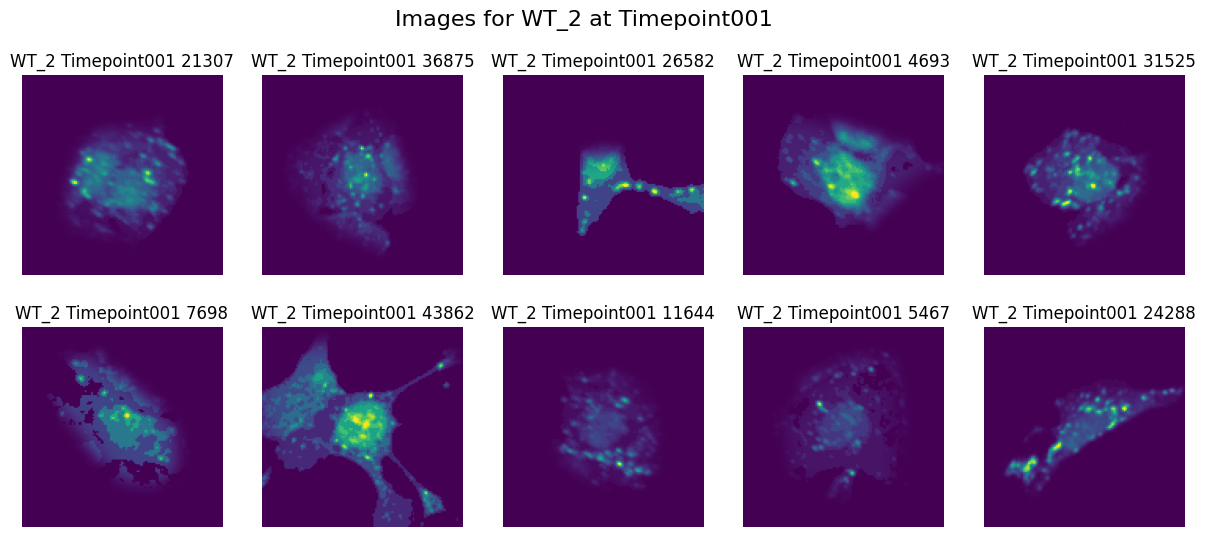

In [3]:
hdf5_file_path = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/single_cells.h5'

with h5py.File(hdf5_file_path, 'r') as hdf5:
    single_cell_data = hdf5['single_cell_data'][:]  
    single_cell_labels = hdf5['single_cell_index_labelled'][:] 
    
    # Extract unique timepoints
    timepoints = np.unique(single_cell_labels[:, 4])  # Timepoint is in 5th!!! 
    print(f"Unique Timepoints: {timepoints}")
    
    # Filter WT_1 and WT_2
    wt_classes = [b'WT_1', b'WT_2']
    for wt_class in wt_classes:
        for timepoint in timepoints:
            # indices for the current WT class and timepoint
            indices = np.where((single_cell_labels[:, 7] == wt_class) & (single_cell_labels[:, 4] == timepoint))[0]
            
            # 10 random images from the available indices
            if len(indices) >= 10:
                selected_indices = random.sample(list(indices), 10)
            else:
                selected_indices = indices  
            
            # Plot images
            plt.figure(figsize=(15, 6))
            for i, idx in enumerate(selected_indices, 1):
                img = single_cell_data[idx, 4, :, :] 
                
                plt.subplot(2, 5, i)  
                plt.imshow(img, cmap='viridis')
                plt.title(f'{wt_class.decode()} {timepoint.decode()} {idx}')
                plt.axis('off')  # Hide axis for better visualization
            
            plt.suptitle(f"Images for {wt_class.decode()} at {timepoint.decode()}", fontsize=16)
            plt.show()

In [19]:
!ls -l /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/

total 2
drwxrws--- 2 nobody nogroup 4096 Nov  6 18:43 231018_0316_EI24_fixed_tc
drwxrws--- 2 nobody nogroup 4096 Nov  6 18:44 231018_0317_EI24_fixed_tc
drwxrws--- 2 nobody nogroup 4096 Nov  6 18:45 231018_0318_EI24_fixed_tc


In [3]:
input_dir = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/'

file_paths = [
    os.path.join(input_dir, '231018_0316_EI24_fixed_tc', 'single_cells.h5'),
    os.path.join(input_dir, '231018_0317_EI24_fixed_tc', 'single_cells.h5'),
    os.path.join(input_dir, '231018_0318_EI24_fixed_tc', 'single_cells.h5')
]

conditions = [b'EI24KO_1', b'EI24KO_2', b'WT_1', b'WT_2']
timepoints = [b'0d', b'2h', b'4h', b'6h', b'8h', b'10h', b'12h', b'14h']

In [4]:
for file_path in file_paths:
    current_folder = os.path.dirname(file_path)  
    file_id = os.path.basename(current_folder) 
    print(file_id)
    
    with h5py.File(file_path, 'r') as hdf5:
        # Extracting datasets to preserve structure
        label_names = hdf5['label_names'][:]
        single_cell_index = hdf5['single_cell_index'][:]
        single_cell_data = hdf5['single_cell_data'][:]
        single_cell_index_labelled = hdf5['single_cell_index_labelled'][:]

        for condition in conditions:
            for timepoint in timepoints:
                # Filter indices where condition and timepoint match
                condition_mask = single_cell_index_labelled[:, 7] == condition
                timepoint_mask = single_cell_index_labelled[:, 8] == timepoint
                indices = np.where(condition_mask & timepoint_mask)[0]
                
                if len(indices) == 0:
                    continue  # Skip if no data

                # Subset the data
                subset_data = single_cell_data[indices]
                subset_index_labelled = single_cell_index_labelled[indices]

                # Output file path - save inside the respective folder
                output_file = f"{file_id}_{condition.decode()}_{timepoint.decode()}.h5"
                output_path = os.path.join(current_folder, output_file)  # Save in the same subdirectory

                # Write to hDF5 file
                with h5py.File(output_path, 'w') as output_hdf5:
                    # Write all datasets, ensuring the full structure
                    output_hdf5.create_dataset('label_names', data=label_names)
                    output_hdf5.create_dataset('single_cell_index', data=single_cell_index)
                    output_hdf5.create_dataset('single_cell_data', data=subset_data)
                    output_hdf5.create_dataset('single_cell_index_labelled', data=subset_index_labelled)

                print(f"Created: {output_path}")
                
    print("Done.")

231018_0316_EI24_fixed_tc
Created: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_1_0d.h5
Created: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_1_2h.h5
Created: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_1_4h.h5
Created: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_1_6h.h5
Created: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_1_8h.h5
Created: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_1_10

In [4]:
import os
import h5py
import numpy as np

for file_path in file_paths: 
    current_folder = os.path.dirname(file_path)  
    file_id = os.path.basename(current_folder) 
    print(file_id)
    
    with h5py.File(file_path, 'r') as hdf5:
        # Extracting datasets to preserve structure
        label_names = hdf5['label_names'][:]
        single_cell_index = hdf5['single_cell_index'][:]  # Original indices
        single_cell_data = hdf5['single_cell_data'][:]
        single_cell_index_labelled = hdf5['single_cell_index_labelled'][:]

        for condition in conditions:
            for timepoint in timepoints:
                # Filter indices where condition and timepoint match
                condition_mask = single_cell_index_labelled[:, 7] == condition
                timepoint_mask = single_cell_index_labelled[:, 8] == timepoint
                indices = np.where(condition_mask & timepoint_mask)[0]
                
                if len(indices) == 0:
                    continue  # Skip if no data

                # Subset the data
                subset_data = single_cell_data[indices]
                subset_index_labelled = single_cell_index_labelled[indices]

                # Reindex the filtered data starting from 0, 1, 2, ...
                new_single_cell_index = np.zeros((len(indices), 2), dtype=single_cell_index.dtype)
                new_single_cell_index[:, 0] = np.arange(len(indices))  # New indices starting from 0
                new_single_cell_index[:, 1] = np.arange(len(indices))  # Keep the second column as a sequential index

                # Output file path - save inside the respective folder
                output_file = f"{file_id}_{condition.decode()}_{timepoint.decode()}.h5"
                output_path = os.path.join(current_folder, output_file)  # Save in the same subdirectory

                # Write to hDF5 file
                with h5py.File(output_path, 'w') as output_hdf5:
                    # Write all datasets, ensuring the full structure
                    output_hdf5.create_dataset('label_names', data=label_names)
                    output_hdf5.create_dataset('single_cell_index', data=new_single_cell_index)  # New indexed values
                    output_hdf5.create_dataset('single_cell_data', data=subset_data)
                    output_hdf5.create_dataset('single_cell_index_labelled', data=subset_index_labelled)

                print(f"Created: {output_path}")
                
    print("Done.")

231018_0316_EI24_fixed_tc
Created: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_1_0d.h5
Created: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_1_2h.h5
Created: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_1_4h.h5
Created: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_1_6h.h5
Created: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_1_8h.h5
Created: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_1_10

In [5]:
!ls -l /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/

total 9244992
-rw-rw---- 1 di93quv nogroup  297864624 Nov 10 14:51 231018_0316_EI24_fixed_tc_EI24KO_1_0d.h5
-rw-rw---- 1 di93quv nogroup  335814160 Nov 10 14:51 231018_0316_EI24_fixed_tc_EI24KO_1_10h.h5
-rw-rw---- 1 di93quv nogroup  273051472 Nov 10 14:51 231018_0316_EI24_fixed_tc_EI24KO_1_12h.h5
-rw-rw---- 1 di93quv nogroup  261063088 Nov 10 14:51 231018_0316_EI24_fixed_tc_EI24KO_1_14h.h5
-rw-rw---- 1 di93quv nogroup  263359088 Nov 10 14:51 231018_0316_EI24_fixed_tc_EI24KO_1_2h.h5
-rw-rw---- 1 di93quv nogroup  413849328 Nov 10 14:51 231018_0316_EI24_fixed_tc_EI24KO_1_4h.h5
-rw-rw---- 1 di93quv nogroup  364579696 Nov 10 14:51 231018_0316_EI24_fixed_tc_EI24KO_1_6h.h5
-rw-rw---- 1 di93quv nogroup  400561232 Nov 10 14:51 231018_0316_EI24_fixed_tc_EI24KO_1_8h.h5
-rw-rw---- 1 di93quv nogroup  230337744 Nov 10 14:51 231018_0316_EI24_fixed_tc_EI24KO_2_0d.h5
-rw-rw---- 1 di93quv nogroup  196660400 Nov 10 14:51 231018_0316_EI24_fixed_tc_EI24KO_2_10h.h5
-rw-rw---- 1 di93quv nogroup  185820016 No

In [6]:
#Inspect the HDF5 file structure after creating the new hdf5 files
def inspect_hdf5_file(hdf5_path):
    with h5py.File(hdf5_path, "r") as hdf5_file:
        keys = list(hdf5_file.keys())
        print(f"Keys: {keys}\n")

        # Iterate over each key
        for key in keys:
            print(f"Key: {key}")
            dataset = hdf5_file[key]
            print(f" - Shape: {dataset.shape}")
            print(f" - Data type: {dataset.dtype}")
            
            # Print first 5 elements
            if len(dataset.shape) == 1:
                print(f" - Sample data: {dataset[:5]}")
            elif len(dataset.shape) == 2:
                print(f" - Sample data (first 5 rows): \n{dataset[:5, :]}")
            elif len(dataset.shape) == 3:
                print(f" - Sample data (first 5 rows, first channel): \n{dataset[:5, :, 0]}")
            print("\n")

# List of HDF5 file paths 
hdf5_paths = [
    '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_10h.h5', # single example new hdf5 file
    '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/single_cells.h5' # original full file
]

# Inspect each thing
for hdf5_path in hdf5_paths:
    print(f"Inspecting file: {hdf5_path}")
    inspect_hdf5_file(hdf5_path)
    print("=" * 160 + "\n")

Inspecting file: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_10h.h5
Keys: ['label_names', 'single_cell_data', 'single_cell_index', 'single_cell_index_labelled']

Key: label_names
 - Shape: (9,)
 - Data type: object
 - Sample data: [b'index' b'cellid' b'ID' b'location' b'timepoint']


Key: single_cell_data
 - Shape: (1454, 5, 128, 128)
 - Data type: float16


Key: single_cell_index
 - Shape: (1454, 2)
 - Data type: uint64
 - Sample data (first 5 rows): 
[[0 0]
 [1 1]
 [2 2]
 [3 3]
 [4 4]]


Key: single_cell_index_labelled
 - Shape: (1454, 9)
 - Data type: object
 - Sample data (first 5 rows): 
[[b'1014' b'1211' b'Row01_Well03_r002_c001_Timepoint001'
  b'Row01_Well03_r002_c001' b'Timepoint001' b'Row01_Well03' b'r002_c001'
  b'WT_1' b'10h']
 [b'1015' b'1212' b'Row01_Well03_r002_c001_Timepoint001'
  b'Row01_Well03_r002_c001' b'Timepoint001' b'Row01_Well03' b'r002_c001'
  b'WT_1' b'10h']
 [b'

In order to annotate properly, we want the following plot: 

* 12 Images Per Timepoint: From each timepoint file per genotype, choose randomely 4 images, resulting in 12 images from three files for each timepoint.
* 8 Columns representing each timepoint.
* 4 blocks (one for each genotype).

In other words, we get 4 images from each timepoint per genotype per file, arranged in columns by timepoints, within separate blocks for each genotype.

In [7]:
genotypes = [b'EI24KO_1', b'EI24KO_2', b'WT_1', b'WT_2']
timepoints = [b'0d', b'2h', b'4h', b'6h', b'8h', b'10h', b'12h', b'14h']

input_dir = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/'
file_paths = [
    os.path.join(input_dir, '231018_0316_EI24_fixed_tc', 'single_cells.h5'),
    os.path.join(input_dir, '231018_0317_EI24_fixed_tc', 'single_cells.h5'),
    os.path.join(input_dir, '231018_0318_EI24_fixed_tc', 'single_cells.h5')
]

In [9]:
for genotype in genotypes:
    fig, axes = plt.subplots(12, len(timepoints), figsize=(20, 24))
    fig.suptitle(f"Single Cell Data for Genotype: {genotype.decode()}", fontsize=20)

    # Loop over timepoints (columns) and files (rows)
    for col_idx, timepoint in enumerate(timepoints):
        image_count = 0  

        for file_idx, file_path in enumerate(file_paths):
            with h5py.File(file_path, 'r') as hdf5:
                single_cell_data = hdf5['single_cell_data']  
                single_cell_labels = hdf5['single_cell_index_labelled']

                genotype_mask = single_cell_labels[:, 7] == genotype
                timepoint_mask = single_cell_labels[:, 8] == timepoint
                indices = np.where(genotype_mask & timepoint_mask)[0]

                # Randomly select up to 4 indices per file
                if len(indices) >= 4:
                    selected_indices = random.sample(list(indices), 4)
                else:
                    selected_indices = indices  # If fewer than 4, use all 

                for idx in selected_indices:
                    img = single_cell_data[idx, 4, :, :]
                    ax = axes[image_count, col_idx]
                    ax.imshow(img, cmap='viridis')
                    ax.axis('off') 
                    image_count += 1

        axes[0, col_idx].set_title(f"{timepoint.decode()}", fontsize=14)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"{genotype.decode()}_timecourse.png", dpi=150)
    plt.close(fig) 

print("All genotype plots generated and saved.")

All genotype plots generated and saved.


We take EI24KO 14hrs and wt 4hrs. Both are different from wt 0h and wt 14hrs.

In [8]:
import h5py
import matplotlib.pyplot as plt

num_channels = 5

channel_info = {
    1: "mask nucleus",
    2: "mask cytosol",
    3: "img nucleus",
    4: "img membrane",
    5: "img LC3"
}

In [9]:
# El24 KO timecourse
El24_KO_hdf5_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_EI24KO_1_0d.h5"
El24_KO_hdf5 = h5py.File(El24_KO_hdf5_path, "r")
El24_KO_hdf5.keys()

<KeysViewHDF5 ['label_names', 'single_cell_data', 'single_cell_index', 'single_cell_index_labelled']>

In [10]:
El24_KO_timeseries_index_hdf5 = El24_KO_hdf5["single_cell_index"][:]
El24_KO_timeseries_cells_hdf5 = El24_KO_hdf5["single_cell_data"][0:100, :]

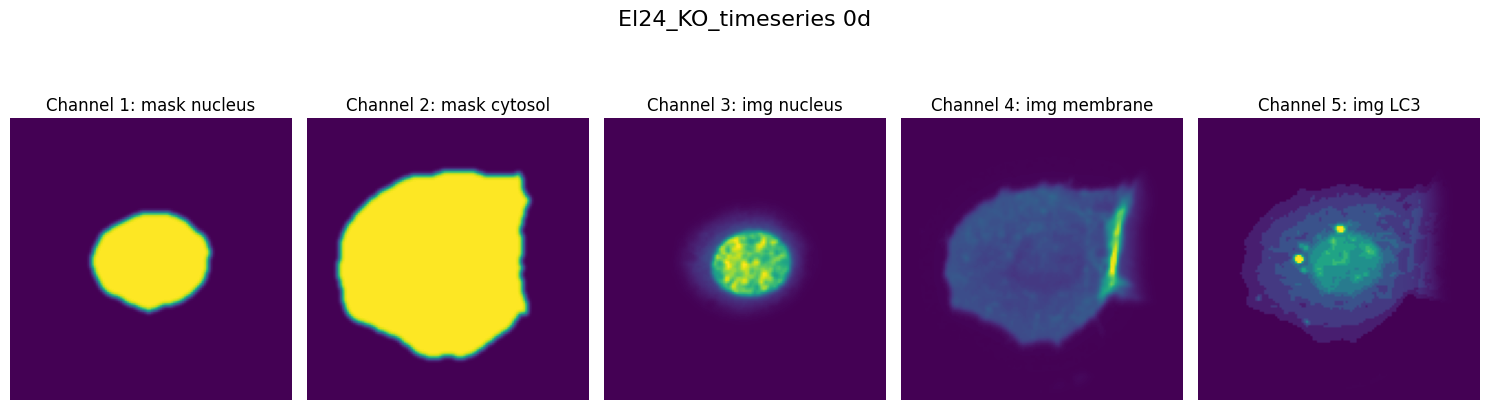

In [11]:
# Create a figure with subplots for each channel
fig, axes = plt.subplots(1, num_channels, figsize=(15, 5))

for channel in range(num_channels):
    axes[channel].imshow(El24_KO_timeseries_cells_hdf5[0][channel])
    axes[channel].set_title(f"Channel {channel+1}: {channel_info[channel+1]}")
    axes[channel].axis('off')
plt.tight_layout()
main_title = "El24_KO_timeseries 0d"
plt.suptitle(main_title, fontsize=16, y=1.)
plt.show()